# This code will train the model and save weights  using a data generator

First Import libraries

In [1]:
import os
import numpy as np
import keras
import tensorflow
from sklearn.model_selection import train_test_split
import nibabel as nib
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

Using TensorFlow backend.


ModuleNotFoundError: No module named 'keras.api'

In [19]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [20]:
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Define our Data Generator and other functions to be used later

In [21]:
from Data_Gen import DataGenerator 

In [22]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

In [23]:
def gather_set_and_path(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(str(data_path+f))
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

In [24]:
def gather_set_and_path_msk(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        phrase2 = f[-7]
        if phrase2.isnumeric():
            set_of.append(str(data_path+f))
        else:
            continue
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

Define the paths where images and segmentations are located. Gather into groups and arrange into a dictionary that can be split up for training, testing, and validation for the model

## Expected Dimmentions

Image: (512,512) range: 0:255

Label: (512,512) range: 0:1

In [25]:
data_path_1 = r"C:\Users\UAB\data\KU\data\\"
data_path_2 = r"C:\Users\UAB\data\Mayo\data\\"
data_path_3 = r"C:\Users\UAB\data\Emory\data\\"
data_path_4 = r"C:\Users\UAB\data\UAB\data\\"

images_1 = gather_set_and_path(data_path_1, '_M')
images_2 = gather_set_and_path(data_path_2, '_M')
images_3 = gather_set_and_path(data_path_3, '_M')
images_4 = gather_set_and_path(data_path_4, '_M')


images = images_1+images_2+images_3+images_4

print(len(images))



77885


In [26]:
print(len(images_1))
print(len(images_2))
print(len(images_3))
print(len(images_4))


26082
21037
23488
7278


C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_M.npy


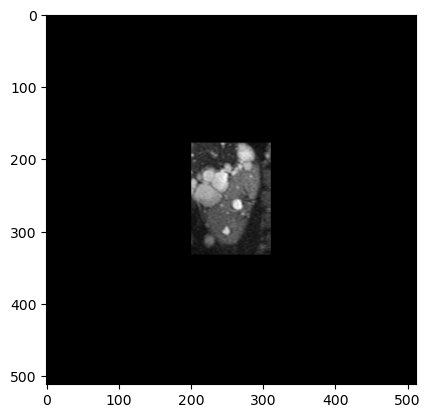

In [27]:
%matplotlib inline
print(images[-1500])
image = np.load(images[-1500])
plt.imshow(image, cmap='gray')
 


In [28]:
labels_1 = gather_set_and_path_msk(data_path_1, '_K')
labels_2 = gather_set_and_path_msk(data_path_2, '_K')
labels_3 = gather_set_and_path_msk(data_path_3, '_K')
labels_4 = gather_set_and_path_msk(data_path_4, '_K')

labels = labels_1 + labels_2 + labels_3 + labels_4
print(len(labels))


101373


In [29]:
print(labels_1[1][-7])
print(labels_1[1])

0
C:\Users\UAB\data\KU\data\\KU_101934_0_96_L_10_K.npy


In [30]:
test_img = np.load(images[100])
print(test_img.shape)
test_lab = np.load(labels[100])
print(test_lab.shape)


(512, 512)
(512, 512)


## Define Image and Label ID for data generator

Here the "test train split" will need to be replaced so we have the whole patient in one or the other"


In [31]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [32]:
print(len(labels))

77885


In [33]:
import os
img_name = os.path.basename(images[0])[0:11]
print(img_name)

KU_101934_0


## Image separation for entire patient in training or validation - use with single set of images


In [15]:
from sklearn.model_selection import train_test_split


id_list = []   
for i in range(len(images)):
    image_name = os.path.basename(images[i])
    unique_id =  image_name[0:11]
    id_list.append(unique_id)

unique_ids = list(set(id_list))

In [16]:
print(len(unique_ids))

350


In [17]:
train, val = train_test_split(unique_ids, train_size = 0.8)

In [18]:
print(len(train))
print(len(val))

280
70


In [19]:
print(train[0:2])

['KU_161547_2', 'KU_173203_0']


In [20]:
#use this when images do not contain filepath:
#train_list = [image for image in images if image[0:8] in train]
#val_list = [image for image in images if image[0:8] in val] 

In [21]:
train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train):
        train_list.append(images[i])

In [22]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val):
        val_list.append(images[i])

In [23]:
print(len(train_list))
print(len(val_list))
print(len(train_list)+len(val_list))
print(len(images))

61505
16380
77885
77885


In [24]:
partition = {'train':train_list, 'validation':val_list}

In [25]:
print(len(train_list))
print(len(val_list))
print(len(train))
print(len(val))

61505
16380
280
70


## Use for given excel file

In [165]:
import pandas as pd
df = pd.read_excel (r"C:\Users\UAB\Kidney-Segmentation-Jupyter\Data for AI development.xlsx", engine='openpyxl')

In [166]:
df = df.iloc[1: , 0:4]
df. columns=df. iloc[0] 

In [167]:
df2 = df.filter(regex='Validation')
df2 = df2.iloc[:,0].dropna()
val_csv_list = df2.values.tolist()
val_csv_list = val_csv_list[1:]

In [168]:
df3 = df.filter(regex='Training')
df3 = df3.iloc[:,0].dropna()
train_csv_list = df3.values.tolist()
train_csv_list = train_csv_list[1:]

In [169]:
print(len(train_csv_list))
print(train_csv_list[0])
print(len(val_csv_list))
print(val_csv_list[0])

151
439240L
19
419258L


In [170]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [171]:
id_list = []   
for i in range(len(images)):
    image_name = os.path.basename(images[i])
    unique_id =  image_name[0:17]
    id_list.append(unique_id)

unique_ids = list(set(id_list))

In [172]:
train_sets=[]
for i in range(len(train_csv_list)):
    phrase1 = train_csv_list[i][:-2]
    phrase2 = train_csv_list[i][-1]
    #print(phrase1, phrase2)
    for z in range(len(unique_ids)):
        name = unique_ids[z]
        if phrase1 in name:
            if phrase2 in name:
                train_sets.append(name)
            else:
                continue
        else:
            continue

In [173]:
val_sets=[]
for i in range(len(val_csv_list)):
    phrase1 = val_csv_list[i][:-2]
    phrase2 = val_csv_list[i][-1]
    #print(phrase1, phrase2)
    for z in range(len(unique_ids)):
        name = unique_ids[z]
        if phrase1 in name:
            if phrase2 in name:
                val_sets.append(name)
            else:
                continue
        else:
            continue

In [174]:
train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train_sets):
        train_list.append(images[i])

In [175]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val_sets):
        val_list.append(images[i])

In [28]:
print(len(train_list))
print(len(val_list))
partition = {'train':train_list, 'validation':val_list}

60327
8516


## Use for crossfold validation:

In [34]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [35]:
print(len(train_list))

NameError: name 'train_list' is not defined

In [17]:
train_sets = ["EM_"]
val_sets = ["EM_"]

train_list_new = []
for i in range(len(train_list)):
    if any(phrase in train_list[i] for phrase in train_sets):
        train_list_new.append(train_list[i])


NameError: name 'train_list' is not defined

In [179]:
print(len(train_list))
print(len(train_list_new))
print(train_list_new[5000])

60327
5432
C:\Users\UAB\data\UAB\data\\UB_492327_2_140_L_8_M.npy


In [180]:
val_list_new = [] 
for i in range(len(val_list)):
    if any(phrase in val_list[i] for phrase in val_sets):
        val_list_new.append(val_list[i])


In [181]:
print(len(val_list))
print(len(val_list_new))
print(val_list_new[100])

8516
994
C:\Users\UAB\data\UAB\data\\UB_419258_0_108_L_93_M.npy


In [182]:
partition = {'train':train_list_new, 'validation':val_list_new}
print(len(train_list))
print(len(val_list))

60327
8516


# Create our data generators 

In [183]:
params = {'dim': (512,512),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

In [184]:
X,y = training_generator[8]
print(X.shape, y.shape)

(32, 512, 512, 1) (32, 512, 512, 2)


## View output

(512, 512) 245.0 0.0


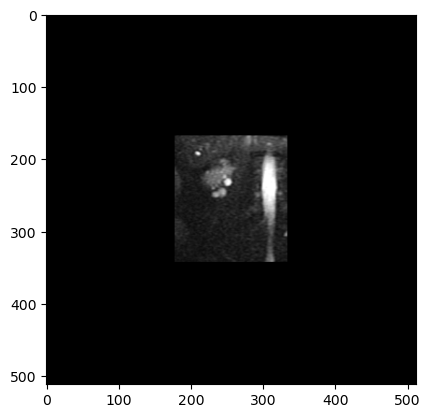

In [185]:
n = 11
X_batch = X[n,:,:,:]
X_batch.shape
X_img = X_batch[:,:,0]
print(X_img.shape, X_img.max(), X_img.min())

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_img, cmap="gray")

(512, 512) 1.0 0.0


<Figure size 640x480 with 0 Axes>

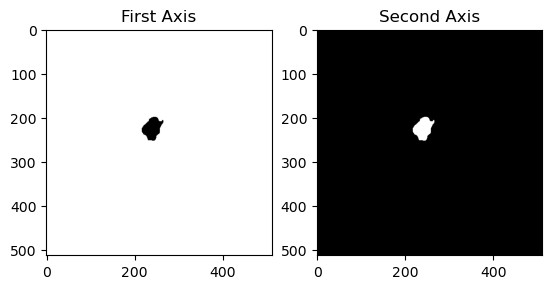

In [186]:
y_batch = y[n,:,:,:]
y_batch.shape
y_img_0 = y_batch[:,:,0]
y_img_1 = y_batch[:,:,1]
print(y_img_0.shape, y_img_0.max(), y_img_0.min())


plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(y_img_0, cmap="gray")
axarr[0].title.set_text('First Axis')
axarr[1].imshow(y_img_1, cmap='gray')
axarr[1].title.set_text('Second Axis')

In [188]:
model = custom_unet(input_shape=(512,512,1), num_classes=2)
#model.summary()

In [189]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
filepath = "UAB-kidneys-35.h5"
model_name = filepath
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
cb = TimingCallback()

In [190]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=jaccard_distance,
  metrics=[dice_coef])

In [191]:
# Train model on dataset
history = model.fit(training_generator, epochs = 35,
                    validation_data = validation_generator,
                    use_multiprocessing=False,
                    workers=6, batch_size = 32,callbacks=[cb])

Epoch 1/35
169/169 [==============================] - 75s 422ms/step - loss: 0.6673 - dice_coef: 0.6621 - val_loss: 0.3215 - val_dice_coef: 0.8287
Epoch 2/35
169/169 [==============================] - 73s 431ms/step - loss: 0.4495 - dice_coef: 0.7708 - val_loss: 0.3530 - val_dice_coef: 0.8055
Epoch 3/35
169/169 [==============================] - 74s 432ms/step - loss: 0.3573 - dice_coef: 0.8174 - val_loss: 0.2066 - val_dice_coef: 0.8905
Epoch 4/35
169/169 [==============================] - 73s 432ms/step - loss: 0.2752 - dice_coef: 0.8585 - val_loss: 0.2357 - val_dice_coef: 0.8730
Epoch 5/35
169/169 [==============================] - 73s 431ms/step - loss: 0.2206 - dice_coef: 0.8861 - val_loss: 0.1701 - val_dice_coef: 0.9093
Epoch 6/35
169/169 [==============================] - 73s 431ms/step - loss: 0.1802 - dice_coef: 0.9067 - val_loss: 0.1546 - val_dice_coef: 0.9176
Epoch 7/35
169/169 [==============================] - 73s 431ms/step - loss: 0.1479 - dice_coef: 0.9233 - val_loss: 0.

In [192]:
from keras.models import Sequential, load_model
model.save(model_name)   

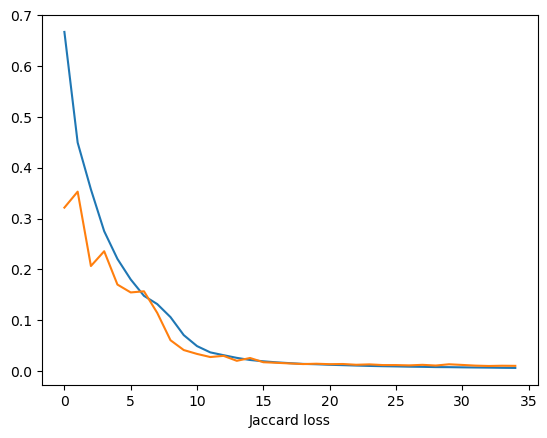

In [193]:
%matplotlib inline
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

plt.show()

Text(0.5, 0, 'Dice coefficient')

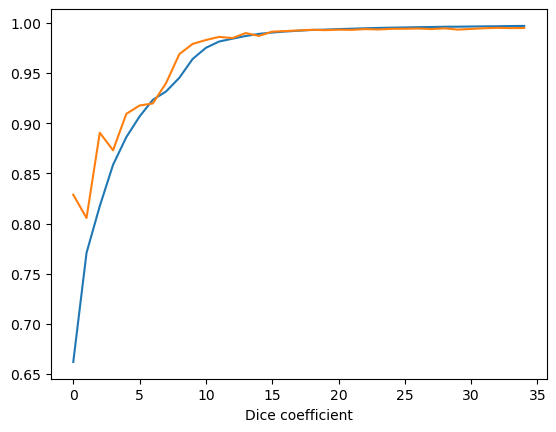

In [194]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')

In [195]:
print(sum(cb.logs)/3600)
import pandas as pd
df = pd.DataFrame.from_dict(history.history)

0.7121707845833336


In [196]:
df['epoch_time'] = np.array(cb.logs)
df.to_csv('kidney_seg_UAB_35epoch.csv')